# SqueezeNet-1.1: CIFAR-10 + PyTorch with _fine-tuning_

using ```albumentations``` and learning rate scheduler. To read the research paper, refer to _SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5 MB model size_ by 
Forrest N. Iandola et al.

[Finetuning torchvision CNN architectures reference](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models
# import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2

C:\Users\arjun\anaconda3\envs\torch-cuda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 1.13.1
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU
Available device is cuda


In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 40

In [5]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)

In [6]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label
    

In [7]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    download = True, transform = transform_train
)

val_dataset = Cifar10Dataset(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    download = True, transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Define train and validate loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size = batch_size,
    shuffle = True
    )

In [9]:
print(f"len(train_dataset) = {len(train_dataset)} & len(val_dataset) = {len(val_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(val_loader) = {len(val_loader)}")

# Sanity check-
len(train_dataset) / batch_size, len(val_dataset) / batch_size

len(train_dataset) = 50000 & len(val_dataset) = 10000
len(train_loader) = 196 & len(val_loader) = 40


(195.3125, 39.0625)

### Use pre-trained _SqueezeNet-1.1_ CNN

In [10]:
# Load pre-trained SqueezeNet-1.1 model-
model = models.squeezenet1_1(weights = torchvision.models.SqueezeNet1_1_Weights.DEFAULT)

# Side note:
# ResNet-18 model size = 44.6 MB
# ResNet-50 model size = 97.7 MB
# SqueezeNet-1.1 model size = 4.72 MB!

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to C:\Users\arjun/.cache\torch\hub\checkpoints\squeezenet1_1-b8a52dc0.pth
100%|█████████████████████████████████████████████████████████████████████████████| 4.73M/4.73M [00:00<00:00, 5.56MB/s]


In [11]:
# Modify output layer to have 10 instead of 1000 output neurons-
model.classifier[1] = nn.Conv2d(
    in_channels = 512, out_channels = 10,
    kernel_size = 1, padding = 1,
        stride = 1, bias = True
)

In [20]:
# Remove max pooling, not needed for CIFAR-10-
del model.features[2]

In [22]:
# Sanity check-
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [23]:
# Place model on GPU-
model = model.to(device)

In [25]:
# Define cost function-
loss = nn.CrossEntropyLoss()

# Learning rate - Observe that all parameters are being optimized-
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

#### Note

All layer weights are trained instead of freezing some layers as feature extractors and training newly added layers.

In [26]:
# Learning rate scheduler - Decay LR by a factor of 0.1 every 15 epochs-
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)

In [27]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # global step
            # optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)
            # step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()

def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()
    

In [28]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 80

In [29]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = val_loader,
        test_dataset = val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.5f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    exp_lr_scheduler.step()
    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "SqueezeNet_best_model.pth")
        

Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 37.83batch/s, val_acc=47.4, val_loss=1.44]



epoch: 1 training loss = 1.9826, training accuracy = 27.86%, val_loss = 1.4448, val_accuracy = 47.38% & LR = 0.00100



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 38.19batch/s, val_acc=56.8, val_loss=1.18]



epoch: 2 training loss = 1.5360, training accuracy = 43.95%, val_loss = 1.1801, val_accuracy = 56.77% & LR = 0.00100



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 37.66batch/s, val_acc=58.7, val_loss=1.11]



epoch: 3 training loss = 1.4041, training accuracy = 49.12%, val_loss = 1.1082, val_accuracy = 58.70% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.87batch/s, val_acc=64.9, val_loss=0.989]



epoch: 4 training loss = 1.3248, training accuracy = 52.74%, val_loss = 0.9893, val_accuracy = 64.93% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.52batch/s, val_acc=65.5, val_loss=0.974]



epoch: 5 training loss = 1.2616, training accuracy = 54.82%, val_loss = 0.9739, val_accuracy = 65.53% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.05batch/s, val_acc=66.4, val_loss=0.954]



epoch: 6 training loss = 1.2164, training accuracy = 56.38%, val_loss = 0.9545, val_accuracy = 66.41% & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 38.53batch/s, val_acc=67, val_loss=0.924]



epoch: 7 training loss = 1.1822, training accuracy = 58.01%, val_loss = 0.9242, val_accuracy = 66.99% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.30batch/s, val_acc=69.6, val_loss=0.853]



epoch: 8 training loss = 1.1499, training accuracy = 59.04%, val_loss = 0.8527, val_accuracy = 69.59% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.47batch/s, val_acc=70.5, val_loss=0.828]



epoch: 9 training loss = 1.1269, training accuracy = 59.90%, val_loss = 0.8281, val_accuracy = 70.53% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.24batch/s, val_acc=70.9, val_loss=0.818]



epoch: 10 training loss = 1.0939, training accuracy = 61.36%, val_loss = 0.8177, val_accuracy = 70.93% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.10batch/s, val_acc=68.9, val_loss=0.863]



epoch: 11 training loss = 1.0830, training accuracy = 61.51%, val_loss = 0.8626, val_accuracy = 68.92% & LR = 0.00100



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 34.74batch/s, val_acc=71.7, val_loss=0.8]



epoch: 12 training loss = 1.0623, training accuracy = 62.29%, val_loss = 0.8004, val_accuracy = 71.66% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 39.08batch/s, val_acc=72.6, val_loss=0.775]



epoch: 13 training loss = 1.0438, training accuracy = 63.08%, val_loss = 0.7752, val_accuracy = 72.59% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.49batch/s, val_acc=71.2, val_loss=0.813]



epoch: 14 training loss = 1.0316, training accuracy = 63.44%, val_loss = 0.8128, val_accuracy = 71.20% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.51batch/s, val_acc=73.3, val_loss=0.752]



epoch: 15 training loss = 1.0059, training accuracy = 64.36%, val_loss = 0.7516, val_accuracy = 73.33% & LR = 0.00100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.62batch/s, val_acc=74.6, val_loss=0.724]



epoch: 16 training loss = 0.9701, training accuracy = 65.56%, val_loss = 0.7239, val_accuracy = 74.59% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 35.54batch/s, val_acc=74.2, val_loss=0.728]



epoch: 17 training loss = 0.9613, training accuracy = 66.05%, val_loss = 0.7279, val_accuracy = 74.22% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.47batch/s, val_acc=74.6, val_loss=0.723]



epoch: 18 training loss = 0.9571, training accuracy = 66.11%, val_loss = 0.7227, val_accuracy = 74.63% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 39.15batch/s, val_acc=74.6, val_loss=0.722]



epoch: 19 training loss = 0.9552, training accuracy = 66.31%, val_loss = 0.7221, val_accuracy = 74.64% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.98batch/s, val_acc=74.3, val_loss=0.728]



epoch: 20 training loss = 0.9545, training accuracy = 66.37%, val_loss = 0.7280, val_accuracy = 74.30% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 39.77batch/s, val_acc=74.8, val_loss=0.712]



epoch: 21 training loss = 0.9616, training accuracy = 66.03%, val_loss = 0.7117, val_accuracy = 74.81% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.36batch/s, val_acc=75.1, val_loss=0.708]



epoch: 22 training loss = 0.9553, training accuracy = 66.27%, val_loss = 0.7076, val_accuracy = 75.10% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 39.31batch/s, val_acc=75.1, val_loss=0.709]



epoch: 23 training loss = 0.9489, training accuracy = 66.29%, val_loss = 0.7088, val_accuracy = 75.15% & LR = 0.00010



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 38.20batch/s, val_acc=74.5, val_loss=0.72]



epoch: 24 training loss = 0.9501, training accuracy = 66.70%, val_loss = 0.7204, val_accuracy = 74.47% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.16batch/s, val_acc=74.8, val_loss=0.711]



epoch: 25 training loss = 0.9493, training accuracy = 66.50%, val_loss = 0.7106, val_accuracy = 74.83% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.24batch/s, val_acc=75.1, val_loss=0.711]



epoch: 26 training loss = 0.9524, training accuracy = 66.30%, val_loss = 0.7106, val_accuracy = 75.06% & LR = 0.00010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 39.08batch/s, val_acc=75, val_loss=0.711]



epoch: 27 training loss = 0.9471, training accuracy = 66.55%, val_loss = 0.7107, val_accuracy = 75.04% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.60batch/s, val_acc=75.1, val_loss=0.704]



epoch: 28 training loss = 0.9427, training accuracy = 66.61%, val_loss = 0.7040, val_accuracy = 75.13% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.09batch/s, val_acc=74.9, val_loss=0.704]



epoch: 29 training loss = 0.9401, training accuracy = 66.95%, val_loss = 0.7045, val_accuracy = 74.85% & LR = 0.00010



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 38.73batch/s, val_acc=75, val_loss=0.706]



epoch: 30 training loss = 0.9406, training accuracy = 66.62%, val_loss = 0.7059, val_accuracy = 74.99% & LR = 0.00010



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.81batch/s, val_acc=75.2, val_loss=0.701]



epoch: 31 training loss = 0.9375, training accuracy = 66.77%, val_loss = 0.7010, val_accuracy = 75.23% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 39.48batch/s, val_acc=75.3, val_loss=0.701]



epoch: 32 training loss = 0.9366, training accuracy = 66.64%, val_loss = 0.7012, val_accuracy = 75.26% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.63batch/s, val_acc=75.2, val_loss=0.701]



epoch: 33 training loss = 0.9353, training accuracy = 66.94%, val_loss = 0.7008, val_accuracy = 75.24% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.80batch/s, val_acc=75.2, val_loss=0.702]



epoch: 34 training loss = 0.9359, training accuracy = 66.71%, val_loss = 0.7015, val_accuracy = 75.24% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.65batch/s, val_acc=75.1, val_loss=0.701]



epoch: 35 training loss = 0.9348, training accuracy = 66.88%, val_loss = 0.7008, val_accuracy = 75.13% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 37.46batch/s, val_acc=75.1, val_loss=0.701]



epoch: 36 training loss = 0.9376, training accuracy = 66.91%, val_loss = 0.7014, val_accuracy = 75.11% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.91batch/s, val_acc=75.2, val_loss=0.702]



epoch: 37 training loss = 0.9319, training accuracy = 66.98%, val_loss = 0.7023, val_accuracy = 75.17% & LR = 0.00001



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 39.56batch/s, val_acc=75.3, val_loss=0.7]



epoch: 38 training loss = 0.9401, training accuracy = 66.75%, val_loss = 0.6998, val_accuracy = 75.29% & LR = 0.00001



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 38.05batch/s, val_acc=75.3, val_loss=0.702]



epoch: 39 training loss = 0.9317, training accuracy = 67.15%, val_loss = 0.7016, val_accuracy = 75.29% & LR = 0.00001



Validation: : 100%|█████████████████████████████████████| 40/40 [00:01<00:00, 37.85batch/s, val_acc=75.3, val_loss=0.7]


epoch: 40 training loss = 0.9327, training accuracy = 67.02%, val_loss = 0.6999, val_accuracy = 75.27% & LR = 0.00001



In [30]:
# Save training metrics as Python3 history for later analysis-
with open("SqueezeNet_CIFAR10_training_history.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

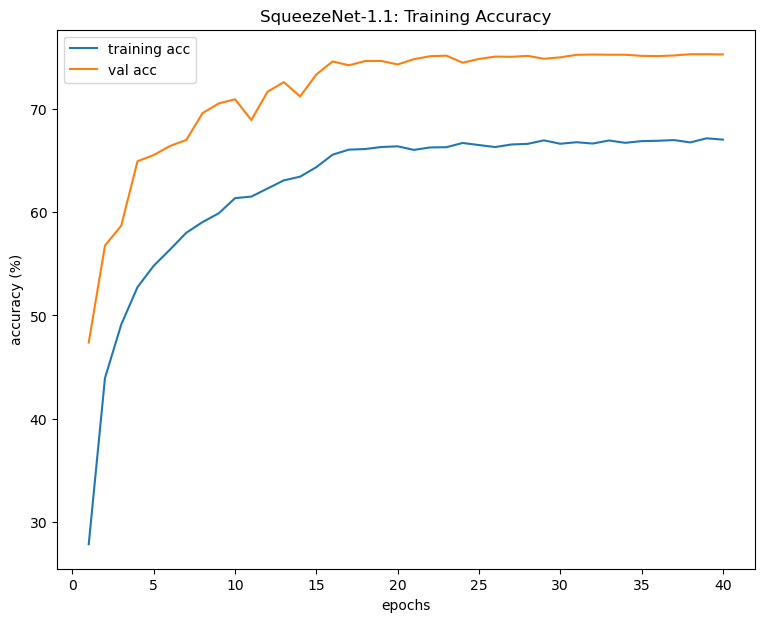

In [31]:
# Visualize ResNet-training-
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("SqueezeNet-1.1: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

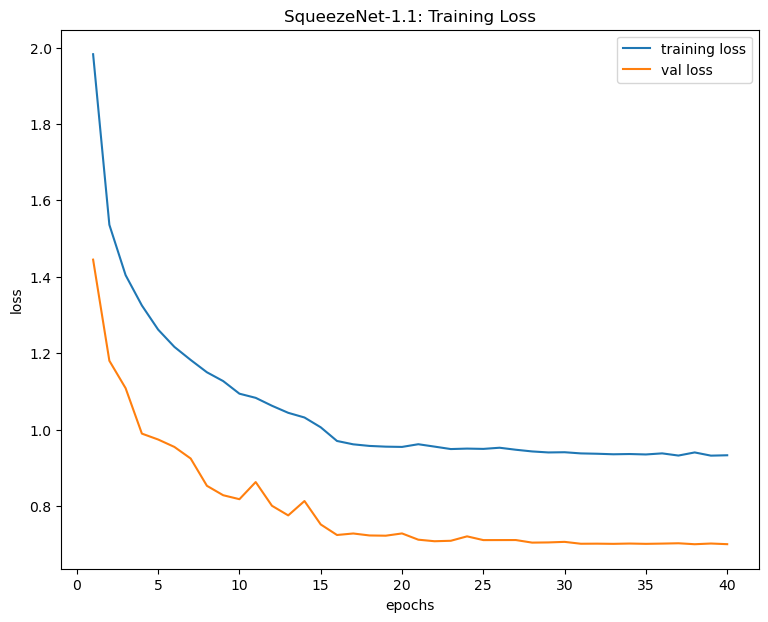

In [32]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("SqueezeNet-1.1: Training Loss")
plt.show()

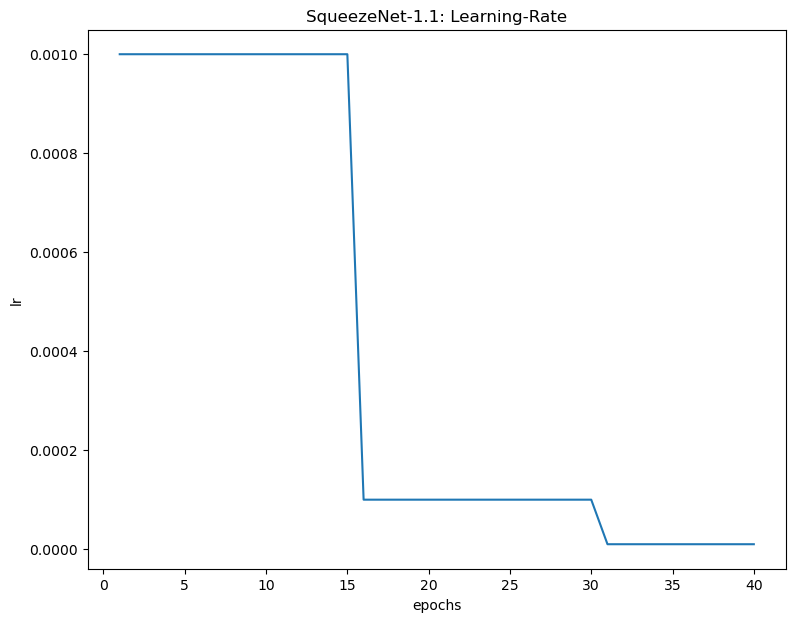

In [33]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("SqueezeNet-1.1: Learning-Rate")
plt.show()

The accuracy achieved is not great.